## Installation
[Install the T4 Python client](https://github.com/quiltdata/t4/blob/master/UserDocs.md), `helium`.

In [1]:
# The name of the bucket you will run this demo against. This must be 
# an S3 bucket you have access to.
bucket_name   = "alpha-quilt-storage"

# The subfolder inside of the bucket that this demo will be placed in.
bucket_folder = "hurdat-demo"

# The local folder that will act as scratch space for some files we
# will create in this notebook.
# This path must end in a forward slash ("/").
local_folder  = "./"

# A date timestamp that will be included in the output path for files
# pushed to S3 by this notebook. Helps ensure tidyness.
from datetime import datetime
bucket_subfolder = str(datetime.now())\
    .replace(" ", "-").replace(":", "_").replace(".", "_")

# Resulting path.
t4_path = f'{bucket_name}/{bucket_folder}/{bucket_subfolder}/'

## Intro
This notebook offers a five-minute tour of the T4 Python API, codename `helium`.

In [2]:
import helium as he

/Users/alex/miniconda3/envs/quilt-dev/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


T4 lets you read and write data from S3. Every file in T4 is searchable, versioned, and secured according to your S3 policies.

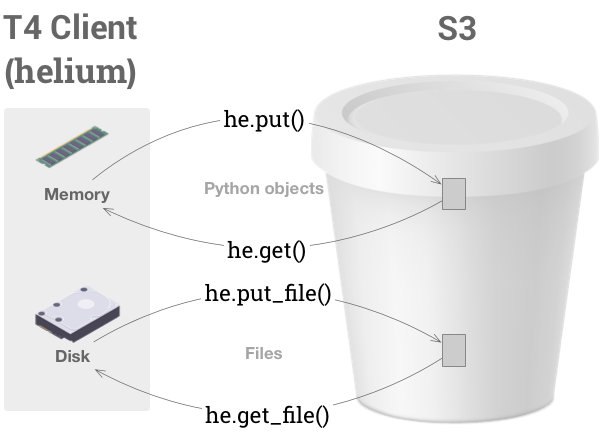

In [1]:
from IPython.display import Image
Image("../img/helium-api.png")

To start off, we'll need some data. Here's a script we've built that downloads and cleans up an NOAA hurricane dataset known as HURDAT. It is pretty typical of the sorts of clean-up scripts you'd be running when performing data science:

In [4]:
%load hurdat/build.py

This script generates a history of Atlantic hurricanes in a `pandas` `DataFrame`:

In [5]:
atlantic_storms.head()

,id,name,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained_wind_knots,maximum_pressure,34_kt_ne,...,34_kt_sw,34_kt_nw,50_kt_ne,50_kt_se,50_kt_sw,50_kt_nw,64_kt_ne,64_kt_se,64_kt_sw,64_kt_nw
index,,,,,,,,,,,,,,,,,,,,,
0,AL011851,UNNAMED,1851-06-25 00:00:00,NaN,HU,28.0,-94.8,80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL011851,UNNAMED,1851-06-25 06:00:00,NaN,HU,28.0,-95.4,80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL011851,UNNAMED,1851-06-25 12:00:00,NaN,HU,28.0,-96.0,80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL011851,UNNAMED,1851-06-25 18:00:00,NaN,HU,28.1,-96.5,80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL011851,UNNAMED,1851-06-25 21:00:00,L,HU,28.2,-96.8,80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Read and write objects

`helium` lets you read and write Python objects with `put()`. `put()` accepts an optional `metadata=` keyword. Use `metadata=` to annotate objects. T4 indexes all metadata so that you can find specific objects or files with `search()`.

In [6]:
he.put(atlantic_storms, t4_path + "atlantic-storms-data.parquet",
       meta={'source': 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2017-050118.txt', 
             'ocean': 'atlantic'})

You can retrieve them (along with the metadata) using `get`:

In [7]:
atlantic_storms, meta = he.get(t4_path + "atlantic-storms-data.parquet")

In [8]:
meta

{'source': 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2017-050118.txt',
 'ocean': 'atlantic'}

`put` transparently chooses file formats for common data structures. In the above example , that meant writing a `pandas.DataFrame` as a `.parquet` file.

To move files to S3, use `put_file`:

In [9]:
local_filepath = f"{local_folder}atlantic-storms.csv"
atlantic_storms.to_csv(local_filepath)

In [10]:
%ls $local_filepath | grep 'atlantic'

./atlantic-storms.csv


In [11]:
he.put_file(local_filepath, t4_path + "atlantic-storms-data.csv")

## Object versions

It is recommended that you use T4 on an S3 bucket with [object versioning](https://docs.aws.amazon.com/AmazonS3/latest/dev/ObjectVersioning.html) enabled.

Every time you write to a versioned S3 bucket, including with `he.put*`, a new *object version* is born. With an object version, you can reconstruct the contents of an object at any point in time.

You can list object version with `ls` command. For example, here are the first three versions of some files in our HURDAT project:

In [12]:
he.ls(t4_path)[1][:3]

[{'ETag': '"701df1515152860cf2a7a8498133ca82"',
  'Size': 3871481,
  'StorageClass': 'STANDARD',
  'Key': 'hurdat-demo/2018-10-11-13_22_16_617100/atlantic-storms-data.csv',
  'VersionId': 's9.iEupWjhaaT7lg1JcRNqK_D3ms8R3M',
  'IsLatest': True,
  'LastModified': datetime.datetime(2018, 10, 11, 20, 22, 54, tzinfo=tzutc()),
  'Owner': {'DisplayName': 'kmoore',
   'ID': '1e740c9f01d3eb40d580b51a943de9c75ba2af0c2f75e1ac7b021cd7afd1872a'}},
 {'ETag': '"502f21cfc143fb0c35f563eda5699fa9"',
  'Size': 923078,
  'StorageClass': 'STANDARD',
  'Key': 'hurdat-demo/2018-10-11-13_22_16_617100/atlantic-storms-data.parquet',
  'VersionId': 'IY3CMAr6G7TtEoG30kR2QHsvEyxz.HjK',
  'IsLatest': True,
  'LastModified': datetime.datetime(2018, 10, 11, 20, 22, 37, tzinfo=tzutc()),
  'Owner': {'DisplayName': 'kmoore',
   'ID': '1e740c9f01d3eb40d580b51a943de9c75ba2af0c2f75e1ac7b021cd7afd1872a'}}]

In the future, T4 will offer other ways of accessing version information more directly.

To grab a specific object version, use the optional `version=` keyword to `get()` or `get_file()`:

In [15]:
# Select and specify the version from the output above.
data, meta = he.get(t4_path + "atlantic-storms-data.parquet", 
                    version="IY3CMAr6G7TtEoG30kR2QHsvEyxz.HjK")

> You'll need to provide the full object version for this to work

## Snapshot folders in S3

<!-- In the future this section should treat versions, not snapshots. -->

A T4 **snapshot** is an immutable picture of one or more objects in S3 at a specific moment in time. Whereas object versions are for single objects, snapshots are for one or more objects.

The snapshot `path` means "seal everything underneath this key" in S3.

In [16]:
he.snapshot(t4_path, message="Initial snapshot")

'17b3c6dea9937dfef9123ef371d927bb3939b6493d49f15ecbdbe3512ac35e40'

You can list snapshots of an S3 key using `list_snapshots`:

In [17]:
he.list_snapshots(
    bucket_name, 

    # e.g. 'hurdat-demo/2018-10-11-11_53_37_098339/'
    contains=f'{bucket_folder}/{bucket_subfolder}/'
)

,hash,timestamp,message
path,,,
hurdat-demo/2018-10-11-13_22_16_617100/,17b3c6dea9937dfef9123ef371d927bb3939b6493d49f1...,2018-10-11 20:24:00+00:00,Initial snapshot
,ad9f3e3d938da7fbc5624245fbcb72f5bc25c2dfe4f9af...,2018-10-08 22:26:29+00:00,foo2
,435d7b954fe6dbd35cf51b311971fc49643d24af9f6f69...,2018-10-08 21:21:01+00:00,foo


You can diff overlapping snapshots to see what's changed. In this case `"latest"` represents what is currently in S3.

In [19]:
he.put({"description": "A simple JSON file"}, 
       t4_path + "simple.json")

In [20]:
# Select and specify the snapshot from the output above.
he.diff(bucket_name, "17b3c6d", "latest")

,Key,ETag
status,,
Added,hurdat-demo/2018-10-11-13_22_16_617100/simple....,"""725f0cda0939ef902a1cb9bcb89923cd"""


Snapshots can be used to version anything with an S3 key, but are at their most useful when versioning **data packages**: groups of files which together represent the data component to a specific project you are working on.

You can think of a data project as having three components: code, environment, and data. Versioning code is obvious: just use `git`. Similarly, sophisticated tools exist for versioning environments: `conda` and Docker, for example.

But what about your data? Data can balloon to many terabytes in size, becoming too large for `git` or Docker to manage. At the same time, in data science, small changes in data can often have disproportionate impact in your analysis and throw off your models. In a [seminal paper](https://ai.google/research/pubs/pub43146) on data systems, Google refered to this as the CACE principle: "Changing Anything Changes Everything". 

Clearly, data needs its own native versioning tool. T4 snapshots provide just that!

To demonstrate, let's start by cloning a simple project using our storms data.

In [21]:
!cd $local_folder; git clone https://github.com/ResidentMario/hurdat-example-repo

Cloning into 'hurdat-example-repo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


This project contains an `environment.yml` file defining our code environment, a `notebooks` folder containing some Jupyter notebooks, and a `data` folder containing inputs and outputs.

Our objective: smartly manage our `data`. With T4 snapshots, this is easy:

In [22]:
he.put_file(
    local_folder + "hurdat-example-repo/data/",
    t4_path + "data/"
)

In [23]:
he.snapshot(t4_path + "data/", message="Snap.")

'61cc385ebfdb5eba5f005605742ebba6cdda4034169809130e38ac73c7da5de3'

In [24]:
he.list_snapshots(bucket_name, 
                  contains=f'{bucket_folder}/{bucket_subfolder}/data/')

,hash,timestamp,message
path,,,
hurdat-demo/2018-10-11-13_22_16_617100/data/,61cc385ebfdb5eba5f005605742ebba6cdda4034169809...,2018-10-11 20:24:35+00:00,Snap.
hurdat-demo/2018-10-11-13_22_16_617100/,17b3c6dea9937dfef9123ef371d927bb3939b6493d49f1...,2018-10-11 20:24:00+00:00,Initial snapshot
,ad9f3e3d938da7fbc5624245fbcb72f5bc25c2dfe4f9af...,2018-10-08 22:26:29+00:00,foo2
,435d7b954fe6dbd35cf51b311971fc49643d24af9f6f69...,2018-10-08 21:21:01+00:00,foo


Now whenever we want to grab a file from a particular snapshot of this particular data project, we need only pass its hash to the `snapshot` parameter of `get_file`:

In [26]:
he.get_file(t4_path + "data/atlantic.csv", 
            local_folder + "atlantic.csv",
            snapshot="61cc38")

Check this hash into your `README.md` and enjoy your newfound project reproducibility!

In summary, every data science product&mdash;be it an analysis, a model, or exposition&mdash;relies on a new collection of data file **versions**, which a data science can logically organize into one (or more) **snapshots**. These snapshots are **immutable**, and, in conjunction with version control on the project code and the project environment, enable reproducible, distributable data science.

## Addendum&mdash;clean up

In [31]:
local_repo      = local_folder + "hurdat-example-repo"
local_data_copy = local_folder + "atlantic-storms.csv"

In [28]:
!rm -rf $local_repo
!rm $local_data_copy